<a href="https://colab.research.google.com/github/zenAurelius/HRAI3/blob/main/notebooks/test_recur1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HRAI/data

Mounted at /content/drive
/content/drive/MyDrive/HRAI/data


In [7]:
df = pd.read_csv('pmu2017_os.zip')
df

,aid_cr,rfs_date,rfs_heure,ris_nom,rfi_prix,rfi_distance,rfs_corde,rfs_condSexe,rfi_nbPartants,rfs_hippodrome,...,OS_N_SG_pis_driver_1,OS_D_MU_pis_entraineur_1,OS_D_SG_pis_entraineur_1,OS_N_MU_pis_entraineur_1,OS_N_SG_pis_entraineur_1,pff_pwin_1,tgf_pwin_1,tgf_pwin_2,pff_foch_1,pff_foch_2
0,170101R01C02,170101,1255,MEULAN,44000,2700,CORDE_GAUCHE,MALES_ET_HONGRES,11,VIN,...,8.227090,1.367565,0.987201,26.367565,8.227090,0.624559,0.550000,0.450000,1500,1500
1,170101R01C02,170101,1255,MEULAN,44000,2700,CORDE_GAUCHE,MALES_ET_HONGRES,11,VIN,...,8.227090,-1.901213,0.987201,23.098787,8.227090,0.624559,0.470588,0.529412,1500,1500
2,170101R01C02,170101,1255,MEULAN,44000,2700,CORDE_GAUCHE,MALES_ET_HONGRES,11,VIN,...,8.227090,-1.901213,0.987201,23.098787,8.227090,0.624559,0.250000,0.750000,1500,1500
3,170101R01C02,170101,1255,MEULAN,44000,2700,CORDE_GAUCHE,MALES_ET_HONGRES,11,VIN,...,8.227090,-1.901213,0.987201,23.098787,8.227090,0.624559,0.357143,0.642857,1500,1500
4,170101R01C02,170101,1255,MEULAN,44000,2700,CORDE_GAUCHE,MALES_ET_HONGRES,11,VIN,...,8.227090,-1.901213,0.987201,23.098787,8.227090,0.624559,0.400000,0.600000,1500,1500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410621,171231R04C07,171231,1530,ORGIE,17000,2825,CORDE_GAUCHE,TOUS_CHEVAUX,18,COR,...,1.003861,0.001128,0.999974,21.108003,0.856488,0.999798,0.521739,0.478261,1500,1500
1410622,171231R04C07,171231,1530,ORGIE,17000,2825,CORDE_GAUCHE,TOUS_CHEVAUX,18,COR,...,1.003453,-0.090292,0.999678,21.016583,0.856235,0.940525,0.153846,0.846154,1500,1500
1410623,171231R04C07,171231,1530,ORGIE,17000,2825,CORDE_GAUCHE,TOUS_CHEVAUX,18,COR,...,1.002983,-0.060518,0.999337,21.046357,0.855942,0.640753,0.352941,0.647059,1500,1500
1410624,171231R04C07,171231,1530,ORGIE,17000,2825,CORDE_GAUCHE,TOUS_CHEVAUX,18,COR,...,1.003273,-0.080788,0.999547,21.026087,0.856122,0.867923,0.388889,0.611111,1500,1500


In [ ]:
df.columns.to_list()

In [8]:
#SELECTION DES FEATURES ET TARGET
#df = df[['rfi_prix','rfi_distance','pfi_chNbPlaces_1','pff_rapportDirect_1','pff_ord_1','pfi_chNbPlaces_2','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df = df[['aid_cr', 'pis_cheval_1','pff_ord_1','pff_ord_2', 'pis_cheval_2','pff_normcote_1','pff_rapportDirect_1','pff_rapportDirect_2','pff_foch_1','pff_normcote_2','pff_foch_2','tgf_pwin_1']].copy()
df = df[(~df.pff_normcote_2.isna()) & (~df.pff_normcote_1.isna())].copy()
df['rel_cote_1'] = df.pff_normcote_1 / (df.pff_normcote_1 + df.pff_normcote_2)
df['rel_force_1'] = df.pff_foch_1 / (df.pff_foch_1 + df.pff_foch_2)
#df = df.sort_values('aid_pt')
df

,aid_cr,pis_cheval_1,pff_ord_1,pff_ord_2,pis_cheval_2,pff_normcote_1,pff_rapportDirect_1,pff_rapportDirect_2,pff_foch_1,pff_normcote_2,pff_foch_2,tgf_pwin_1,rel_cote_1,rel_force_1
0,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DEEPSTACK,0.046082,243.0,7.5,1500,1.322827,1500,0.550000,0.033663,0.5
1,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DAMOUR JIEL,0.046082,243.0,30.0,1500,0.362711,1500,0.470588,0.112727,0.5
2,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DOUGLAS,0.046082,243.0,14.0,1500,0.749602,1500,0.250000,0.057915,0.5
3,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DIABLE DE VAUVERT,0.046082,243.0,7.2,1500,1.371223,1500,0.357143,0.032514,0.5
4,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DADDY CASH,0.046082,243.0,8.7,1500,1.159178,1500,0.400000,0.038234,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410621,171231R04C07,CASH DE FAEL,63.062044,23.016080,CATARINA DE MARZY,2.274325,6.9,199.0,1500,0.089836,1500,0.521739,0.962001,0.5
1410622,171231R04C07,CASH DE FAEL,63.062044,50.070258,CALL ON ME RANAIS,2.274325,6.9,15.0,1500,1.122948,1500,0.153846,0.669456,0.5
1410623,171231R04C07,CASH DE FAEL,63.062044,59.199014,COACH D'OURVILLE,2.274325,6.9,31.0,1500,0.561474,1500,0.352941,0.802005,0.5
1410624,171231R04C07,CASH DE FAEL,63.062044,52.817980,CHEF CADE,2.274325,6.9,23.0,1500,0.748632,1500,0.388889,0.752351,0.5


In [85]:
limit_train = df['aid_cr'].iloc[int(0.8 * len(df))]
limit_val = df['aid_cr'].iloc[int(0.9 * len(df))]
print(limit_train, limit_val)
train = df[df.aid_cr < limit_train].copy()
val = df[(df.aid_cr >= limit_train) & (df.aid_cr < limit_val)].copy()
test = df[df.aid_cr >= limit_val].copy()
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

171022R05C08 171125R04C06
1109226 training examples
138754 validation examples
138678 test examples


In [ ]:
train

,aid_cr,pis_cheval_1,pff_ord_1,pff_ord_2,pis_cheval_2,pff_rapportDirect_1,pff_foch_1,pff_rapportDirect_2,pff_foch_2,tgf_pwin_1,rel_cote_1,rel_force_1
0,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DEEPSTACK,243.0,1500,7.5,1500,0.550000,0.970060,0.5
1,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DAMOUR JIEL,243.0,1500,30.0,1500,0.470588,0.890110,0.5
2,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DOUGLAS,243.0,1500,14.0,1500,0.250000,0.945525,0.5
3,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DIABLE DE VAUVERT,243.0,1500,7.2,1500,0.357143,0.971223,0.5
4,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DADDY CASH,243.0,1500,8.7,1500,0.400000,0.965435,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1127781,171022R05C07,GARFAGNA TOSCANA,14.644504,44.472794,OURIQUE,37.0,1500,28.0,1500,0.312500,0.569231,0.5
1127782,171022R05C07,GARFAGNA TOSCANA,14.644504,2.680375,DECLIC SAUTREUIL,37.0,1500,25.0,1500,0.352941,0.596774,0.5
1127783,171022R05C07,GARFAGNA TOSCANA,14.644504,56.771907,PASSIONATE DREAM,37.0,1500,9.5,1500,0.214286,0.795699,0.5
1127784,171022R05C07,GARFAGNA TOSCANA,14.644504,30.607989,GOLD BUITENZORG,37.0,1500,28.0,1500,0.266667,0.569231,0.5


In [86]:
NUM_FEATURES = ['rel_cote_1', 'rel_force_1']
STR_FEATURES = []
TARGET = ['tgf_pwin_1']
FEATURES = NUM_FEATURES
ALL_COLS = FEATURES + TARGET

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  #df = dataframe[['pff_rapportDirect_1','pff_foch_1','pff_rapportDirect_2','pff_foch_2','tgf_pwin_1']].copy()
  df = dataframe[ALL_COLS].copy()
  labels = df.pop(TARGET[0])
  df = {key: np.array(value)[:,tf.newaxis] for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [12]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [89]:
batch_size = 256
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [67]:
all_inputs = []
encoded_features = []

# Numerical features.
#for header in ['rfi_prix', 'rfi_distance', 'pfi_chNbPlaces_1', 'pff_rapportDirect_1', 'pff_ord_1', 'pfi_chNbPlaces_2', 'pff_rapportDirect_2', 'pff_ord_2']:
for header in NUM_FEATURES:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [76]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))


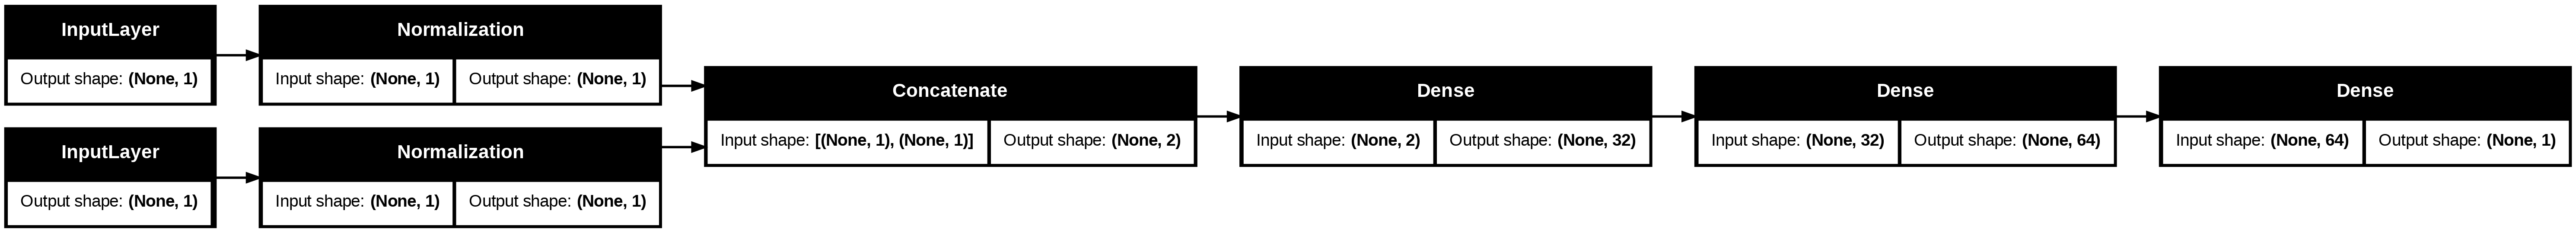

In [17]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [78]:
model.fit(train_ds, epochs=5, validation_data=val_ds)


Epoch 1/5
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0391 - val_loss: 0.0378
Epoch 2/5
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0386 - val_loss: 0.0377
Epoch 3/5
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0384 - val_loss: 0.0376
Epoch 4/5
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.0383 - val_loss: 0.0376
Epoch 5/5
4333/4333 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0383 - val_loss: 0.0376


In [19]:
def predict(model, ds, df, pcol):
  predictions = model.predict(ds)

  df[pcol] = predictions

  threshold = 0.5
  df[f'{pcol}_w'] = (predictions > threshold).astype(int)

  # Le reste pourrait être ailleurs
def prepare_comparaison(df):
  df['win1'] = (df.tgf_pwin_1 > 0.5).astype(int)
  df['win_cote'] = (df['pff_rapportDirect_2'] > df['pff_rapportDirect_1']).astype(int)
  df['win_force'] = (df['pff_foch_1'] > df['pff_foch_2']).astype(int)
  df['win_ord'] = (df['pff_ord_1'] > df['pff_ord_2']).astype(int)

In [71]:
predict(model, train_ds, train, 'pred4')
prepare_comparaison(train)
train

4333/4333 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


,aid_cr,pis_cheval_1,pff_ord_1,pff_ord_2,pis_cheval_2,pff_normcote_1,pff_rapportDirect_1,pff_rapportDirect_2,pff_foch_1,pff_normcote_2,...,ELO_pis_cheval_1,ELO_pis_cheval_2,pred1,pred1_w,pred2,pred2_w,pred3,pred3_w,pred4,pred4_w
0,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DEEPSTACK,0.046082,243.0,7.5,1500.0,1.322827,...,1500.0,1500.0,0.335088,0,0.386756,0,0.335575,0,0.338998,0
1,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DAMOUR JIEL,0.046082,243.0,30.0,1500.0,0.362711,...,1500.0,1500.0,0.352409,0,0.337026,0,0.388364,0,0.357998,0
2,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DOUGLAS,0.046082,243.0,14.0,1500.0,0.749602,...,1500.0,1500.0,0.334267,0,0.353893,0,0.356097,0,0.385272,0
3,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DIABLE DE VAUVERT,0.046082,243.0,7.2,1500.0,1.371223,...,1500.0,1500.0,0.338354,0,0.336290,0,0.334661,0,0.342381,0
4,170101R01C02,DEFI DE MEMARTIN,38.696565,31.696565,DADDY CASH,0.046082,243.0,8.7,1500.0,1.159178,...,1500.0,1500.0,0.383739,0,0.435652,0,0.431418,0,0.433207,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109221,171022R05C07,GARFAGNA TOSCANA,14.644504,44.472794,OURIQUE,0.356219,37.0,28.0,1487.0,0.466769,...,1487.0,1500.0,0.478647,0,0.484263,0,0.475236,0,0.479236,0
1109222,171022R05C07,GARFAGNA TOSCANA,14.644504,2.680375,DECLIC SAUTREUIL,0.356219,37.0,25.0,1487.0,0.520627,...,1487.0,1492.0,0.534473,1,0.478628,0,0.437690,0,0.424865,0
1109223,171022R05C07,GARFAGNA TOSCANA,14.644504,56.771907,PASSIONATE DREAM,0.356219,37.0,9.5,1487.0,1.289172,...,1487.0,1498.0,0.483973,0,0.484438,0,0.481123,0,0.483016,0
1109224,171022R05C07,GARFAGNA TOSCANA,14.644504,30.607989,GOLD BUITENZORG,0.356219,37.0,28.0,1487.0,0.466769,...,1487.0,1485.0,0.423173,0,0.426084,0,0.388043,0,0.386111,0


In [72]:
prepare_comparaison(train)
eval(train, 'pred0')
eval(train, 'pred1')
eval(train, 'pred2')
eval(train, 'pred3')
eval(train, 'pred4')

positifs
0.5938964408051671
0.6319309158884395
0.5963330582207769
negatifs
0.5594018834520534
0.6193132797499813
0.5508806343559608
positifs
0.5807304336863836
0.6319309158884395
0.5963330582207769
negatifs
0.5742484062138956
0.6193132797499813
0.5508806343559608
positifs
0.5899608210829455
0.6319309158884395
0.5963330582207769
negatifs
0.5633948682996567
0.6193132797499813
0.5508806343559608
positifs
0.5844592265463263
0.6319309158884395
0.5963330582207769
negatifs
0.5705629576680437
0.6193132797499813
0.5508806343559608
positifs
0.5901991644194764
0.6319309158884395
0.5963330582207769
negatifs
0.5635943513061981
0.6193132797499813
0.5508806343559608


In [79]:
predict(model, test_ds, test, 'pred')
prepare_comparaison(test)
test

542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,aid_cr,pis_cheval_1,pff_ord_1,pff_ord_2,pis_cheval_2,pff_normcote_1,pff_rapportDirect_1,pff_rapportDirect_2,pff_foch_1,pff_normcote_2,pff_foch_2,tgf_pwin_1,rel_cote_1,rel_force_1,pred,pred_w,win1,win_cote,win_force,win_ord
1269612,171125R04C06,DIKINA,23.128403,24.539405,DEMETER TEGE,0.368710,38.0,28.0,1500,0.495851,1500,0.500000,0.426471,0.5,0.483793,0,0,0,0,0
1269613,171125R04C06,DIKINA,23.128403,21.093656,DAMAROSA BOUILLON,0.368710,38.0,27.0,1500,0.513560,1500,0.214286,0.417910,0.5,0.481084,0,0,0,0,1
1269614,171125R04C06,DIKINA,23.128403,32.778873,DAINA DU MOLETON,0.368710,38.0,75.0,1500,0.189206,1500,0.500000,0.660870,0.5,0.541931,1,0,1,0,0
1269615,171125R04C06,DIKINA,23.128403,42.391760,DOLLY SI,0.368710,38.0,21.0,1500,0.653622,1500,0.266667,0.360656,0.5,0.462966,0,0,0,0,0
1269616,171125R04C06,DIKINA,23.128403,40.578703,DARLING EMERAUDE,0.368710,38.0,39.0,1500,0.359492,1500,0.476190,0.506329,0.5,0.503791,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410621,171231R04C07,CASH DE FAEL,63.062044,23.016080,CATARINA DE MARZY,2.274325,6.9,199.0,1500,0.089836,1500,0.521739,0.962001,0.5,0.661539,1,1,1,0,1
1410622,171231R04C07,CASH DE FAEL,63.062044,50.070258,CALL ON ME RANAIS,2.274325,6.9,15.0,1500,1.122948,1500,0.153846,0.669456,0.5,0.544182,1,0,1,0,1
1410623,171231R04C07,CASH DE FAEL,63.062044,59.199014,COACH D'OURVILLE,2.274325,6.9,31.0,1500,0.561474,1500,0.352941,0.802005,0.5,0.583265,1,0,1,0,1
1410624,171231R04C07,CASH DE FAEL,63.062044,52.817980,CHEF CADE,2.274325,6.9,23.0,1500,0.748632,1500,0.388889,0.752351,0.5,0.567922,1,0,1,0,1


In [30]:
def calc_force_bycr(df, forces, byc, pcol):
  # La force de la prochaine course, calculée à partir de l'erreur de prédiction
  df[f'D_ELO_{byc}'] = 100 * (df.tgf_pwin_1 - df[pcol])
  df[f'NEXT_ELO_{byc}'] = df['pff_foch_1'] + df[f'D_ELO_{byc}']
  # La force calculée à partir de la précédente course => le prochain 'fit' sera fait avec cette valeur
  df[f'ELO_{byc}_1'] = df[f'{byc}_1'].astype(str).map(forces).fillna(df.pff_foch_1)
  df[f'ELO_{byc}_2'] = df[f'{byc}_2'].astype(str).map(forces).fillna(df.pff_foch_2)
  forces.update(df.groupby([f'{byc}_1'])[f'NEXT_ELO_{byc}'].agg("mean").astype(int).to_dict())
  return df.reset_index(drop=True)

def calc_oskill(df, forces, pcol):
  bycr = df.groupby('aid_cr')
  r = bycr.apply(lambda x: calc_force_bycr(x, forces, 'pis_cheval', pcol))
  return r.reset_index(drop=True)

In [80]:
forces = {}
train = calc_oskill(train, forces, 'pred4')
train

KeyboardInterrupt: 

In [73]:
train[['pff_foch_1','pff_foch_2','rel_force_1', 'pff_normcote_1','pff_normcote_2','rel_cote_1','win1','pred0','pred1','pred2','pred3','pred4','tgf_pwin_1']]

,pff_foch_1,pff_foch_2,rel_force_1,pff_normcote_1,pff_normcote_2,rel_cote_1,win1,pred0,pred1,pred2,pred3,pred4,tgf_pwin_1
0,1500.0,1500.0,0.500000,0.046082,1.322827,0.033663,1,0.385775,0.335088,0.386756,0.335575,0.338998,0.550000
1,1500.0,1500.0,0.500000,0.046082,0.362711,0.112727,0,0.333879,0.352409,0.337026,0.388364,0.357998,0.470588
2,1500.0,1500.0,0.500000,0.046082,0.749602,0.057915,0,0.333021,0.334267,0.353893,0.356097,0.385272,0.250000
3,1500.0,1500.0,0.500000,0.046082,1.371223,0.032514,0,0.353488,0.338354,0.336290,0.334661,0.342381,0.357143
4,1500.0,1500.0,0.500000,0.046082,1.159178,0.038234,0,0.430231,0.383739,0.435652,0.431418,0.433207,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109221,1487.0,1500.0,0.497824,0.356219,0.466769,0.432836,0,0.435048,0.478647,0.484263,0.475236,0.479236,0.312500
1109222,1487.0,1492.0,0.499161,0.356219,0.520627,0.406250,0,0.422741,0.534473,0.478628,0.437690,0.424865,0.352941
1109223,1487.0,1498.0,0.498157,0.356219,1.289172,0.216495,0,0.479881,0.483973,0.484438,0.481123,0.483016,0.214286
1109224,1487.0,1485.0,0.500336,0.356219,0.466769,0.432836,0,0.486384,0.423173,0.426084,0.388043,0.386111,0.266667


In [82]:
train.pff_foch_1 = train.ELO_pis_cheval_1
train.pff_foch_2 = train.ELO_pis_cheval_2
train['rel_force_1'] = train.pff_foch_1 / (train.pff_foch_1 + train.pff_foch_2)

In [102]:
def runIteration(num):
  global train
  print(num)
  ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)

  all_inputs = []
  encoded_features = []

  # Numerical features.
  #for header in ['rfi_prix', 'rfi_distance', 'pfi_chNbPlaces_1', 'pff_rapportDirect_1', 'pff_ord_1', 'pfi_chNbPlaces_2', 'pff_rapportDirect_2', 'pff_ord_2']:
  for header in NUM_FEATURES:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

  all_features = tf.keras.layers.concatenate(encoded_features)
  x = tf.keras.layers.Dense(32, activation="relu")(all_features)
  x = layers.Dense(64, activation='relu')(x)
  output = tf.keras.layers.Dense(1)(x)

  model = tf.keras.Model(all_inputs, output)
  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(0.001))

  model.fit(ds, epochs=5, validation_data=val_ds)
  predict(model, ds, train, f'pred{num}')
  forces = {}
  train = calc_oskill(train, forces, f'pred{num}')
  train.pff_foch_1 = train.ELO_pis_cheval_1
  train.pff_foch_2 = train.ELO_pis_cheval_2
  train['rel_force_1'] = train.pff_foch_1 / (train.pff_foch_1 + train.pff_foch_2)

In [ ]:
for x in range(10):
  runIteration(x)

0


In [ ]:
model.save('classifier_test.keras')
reloaded_model = tf.keras.models.load_model('classifier_test.keras')

In [ ]:
predictions = reloaded_model.predict(test_ds)
predictions

542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


array([[0.5411487 ],
       [0.48554975],
       [0.5492399 ],
       ...,
       [0.5081528 ],
       [0.49266246],
       [0.49522945]], dtype=float32)

In [ ]:
train_ds

<_PrefetchDataset element_spec=({'pff_rapportDirect_1': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'pff_foch_1': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'pff_rapportDirect_2': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'pff_foch_2': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [21]:
def eval(df, pcol):
  print('positifs')
  print(len(df[(df[f'{pcol}_w'] == 1) & (df.win1 == 1)]) / len(df[(df.win1 == 1)]))
  print(len(df[(df.win_cote == 1) & (df.win1 == 1)]) / len(df[(df.win1 == 1)]))
  print(len(df[(df.win_ord == 1) & (df.win1 == 1)]) / len(df[(df.win1 == 1)]))
  print('negatifs')
  print(len(df[(df[f'{pcol}_w'] == 0) & (df.win1 == 0)]) / len(df[(df.win1 == 0)]))
  print(len(df[(df.win_cote == 0) & (df.win1 == 0)]) / len(df[(df.win1 == 0)]))
  print(len(df[(df.win_ord == 0) & (df.win1 == 0)]) / len(df[(df.win1 == 0)]))

In [63]:
eval(test, 'pred')

positifs
0.627527948750157
0.6303385253108906
0.6026881045094837
negatifs
0.6218029070542739
0.6187758367782371
0.579303907187625


In [ ]:
test.pff_foch_1 = test.ELO_pis_cheval_1

In [ ]:
train['pred'] = reloaded_model.predict(train_ds)

4334/4334 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step


In [ ]:
train = calc_oskill(train, {})
train

KeyboardInterrupt: 

In [ ]:
train[train.pis_cheval_1 == 'DREAMMOKO'].head(20)

,aid_cr,pis_cheval_1,pis_cheval_2,pff_rapportDirect_1,pff_foch_1,pff_rapportDirect_2,pff_foch_2,tgf_pwin_1,pred,ELO_pis_cheval_1,D_ELO_pis_cheval,NEXT_ELO_pis_cheval
3,170101R01C02,DREAMMOKO,DOUGLAS,39.0,1500.000000,14.0,1500,0.750000,0.506773,1500.000000,4.864547,1504.864547
18,170101R01C02,DREAMMOKO,DORIAN DE SOUVIGNE,39.0,1500.000000,18.0,1500,0.875000,0.485448,1500.000000,7.791046,1507.791046
29,170101R01C02,DREAMMOKO,DEEPSTACK,39.0,1500.000000,7.5,1500,0.916667,0.521537,1500.000000,7.902592,1507.902592
30,170101R01C02,DREAMMOKO,DADDY CASH,39.0,1500.000000,8.7,1500,0.857143,0.435590,1500.000000,8.431064,1508.431064
33,170101R01C02,DREAMMOKO,DZEUS D'AVIGNERE,39.0,1500.000000,76.0,1500,0.916667,0.467435,1500.000000,8.984641,1508.984641
53,170101R01C02,DREAMMOKO,DAMOUR JIEL,39.0,1500.000000,30.0,1500,0.888889,0.443375,1500.000000,8.910281,1508.910281
56,170101R01C02,DREAMMOKO,DEFI DE MEMARTIN,39.0,1500.000000,243.0,1500,0.900000,0.455705,1500.000000,8.885892,1508.885892
63,170101R01C02,DREAMMOKO,DEXTER CHATHO,39.0,1500.000000,2.5,1500,0.666667,0.464880,1500.000000,4.035726,1504.035726
78,170101R01C02,DREAMMOKO,DOOSTY,39.0,1500.000000,5.4,1500,0.800000,0.476672,1500.000000,6.466561,1506.466561
82,170101R01C02,DREAMMOKO,DIABLE DE VAUVERT,39.0,1500.000000,7.2,1500,0.833333,0.308703,1500.000000,10.492598,1510.492598


In [ ]:
train.pff_foch_1 = train.ELO_pis_cheval_1

TEST DE REGRESSION LINEAIRE

In [ ]:

# Define the input layer for 'rel_cote_1'
rel_cote_1_input = tf.keras.Input(shape=(1,), name='rel_cote_1')

# Define the linear regression layer
output = tf.keras.layers.Dense(1, name='tgf_pwin_1')(rel_cote_1_input)

# Create the model
model = tf.keras.Model(inputs=rel_cote_1_input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse') # Use mean squared error for regression

# Prepare the data
X_train = np.array(train['rel_cote_1']).reshape(-1, 1)
y_train = np.array(train['tgf_pwin_1']).reshape(-1, 1)

X_test = np.array(test['rel_cote_1']).reshape(-1, 1)
y_test = np.array(test['tgf_pwin_1']).reshape(-1, 1)

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=256, validation_split=0.2) # Adjust epochs and batch size as needed

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)


Epoch 1/2
3467/3467 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0746 - val_loss: 0.0386
Epoch 2/2
3467/3467 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0386 - val_loss: 0.0386
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 4s 907us/step - loss: 0.0386
Test Loss: 0.03853205218911171
4334/4334 ━━━━━━━━━━━━━━━━━━━━ 4s 806us/step


In [ ]:
test['predr'] = predictions
prepare_comparaison(test)
test['predr_w'] = (predictions > 0.5).astype(int)
test

,aid_cr,pis_cheval_1,pff_ord_1,pff_ord_2,pis_cheval_2,pff_rapportDirect_1,pff_foch_1,pff_rapportDirect_2,pff_foch_2,tgf_pwin_1,rel_cote_1,predr,win1,win_cote,win_force,win_ord,predr_w
1269612,171125R04C06,DIKINA,23.128403,24.539405,DEMETER TEGE,38.0,1500,28.0,1500,0.500000,0.575758,0.484071,0,0,0,0,0
1269613,171125R04C06,DIKINA,23.128403,21.093656,DAMAROSA BOUILLON,38.0,1500,27.0,1500,0.214286,0.584615,0.481522,0,0,0,1,0
1269614,171125R04C06,DIKINA,23.128403,32.778873,DAINA DU MOLETON,38.0,1500,75.0,1500,0.500000,0.336283,0.552985,0,1,0,0,1
1269615,171125R04C06,DIKINA,23.128403,42.391760,DOLLY SI,38.0,1500,21.0,1500,0.266667,0.644068,0.464413,0,0,0,0,0
1269616,171125R04C06,DIKINA,23.128403,40.578703,DARLING EMERAUDE,38.0,1500,39.0,1500,0.476190,0.493506,0.507740,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1410621,171231R04C07,CASH DE FAEL,63.062044,23.016080,CATARINA DE MARZY,6.9,1500,199.0,1500,0.521739,0.033511,0.640113,1,1,0,1,1
1410622,171231R04C07,CASH DE FAEL,63.062044,50.070258,CALL ON ME RANAIS,6.9,1500,15.0,1500,0.153846,0.315068,0.559090,0,1,0,1,1
1410623,171231R04C07,CASH DE FAEL,63.062044,59.199014,COACH D'OURVILLE,6.9,1500,31.0,1500,0.352941,0.182058,0.597366,0,1,0,1,1
1410624,171231R04C07,CASH DE FAEL,63.062044,52.817980,CHEF CADE,6.9,1500,23.0,1500,0.388889,0.230769,0.583348,0,1,0,1,1


In [ ]:
eval(test, 'predr')

positifs
0.6534983042331366
0.6303385253108906
0.6026881045094837
negatifs
0.5952660354713962
0.6187758367782371
0.579303907187625
